**[Colab](https://colab.research.google.com/drive/1t3lSW945YvZjlXgphw2KIC0GBXX1pQa1?usp=sharing)**

In [1]:
!pip install optuna xgboost matplotlib seaborn scikit-learn pandas numpy hyperopt -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.1 MB/s eta 0:00:00


# Импорт библиотек

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor, plot_importance
import optuna
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

C:\Users\anpud\AppData\Roaming\Python\Python313\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Загружаем датасет с данными

In [2]:
data = pd.read_csv('financials.csv', sep=',')

# Создаем новые признаки на основе финансовых мультипликаторов

In [3]:
data['Earnings'] = data['Price'] / data['Price/Earnings']
data['Sales'] = data['Price'] / data['Price/Sales']
data['Book'] = data['Price'] / data['Price/Book']

# Удаление ненужных столбцов и One-Hot Encoding

In [4]:
# Удаляем ненужные столбцы
df = data.drop(['Symbol', 'Name', 'SEC Filings', 'Price', 'Price/Earnings', 'Price/Sales', 'Price/Book'], axis=1)

# One-Hot Encoding для Sector
df_encoded = pd.get_dummies(
    df,
    columns=['Sector'],
    prefix='Sector',
    drop_first=True,
    dtype=int
)

print("\nТипы данных после обработки:")
print(df_encoded.dtypes.value_counts())


Типы данных после обработки:
int64      10
float64     9
Name: count, dtype: int64


# Анализ пропусков и аномалий


Столбцы с пропусками:


,Пропуски,%



Удалено 0 строк с пропусками. Новый размер: (505, 19)


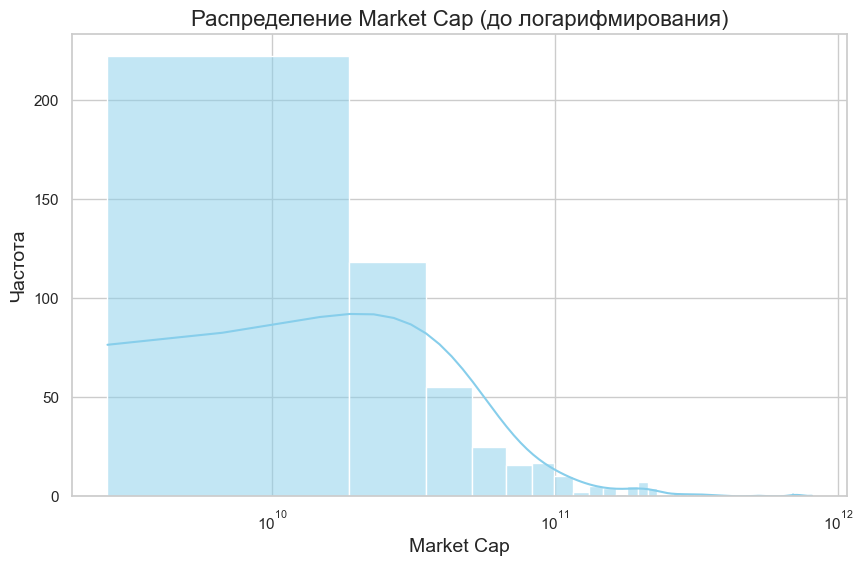

In [6]:
# Проверка пропусков
missing = df_encoded.isnull().sum()
missing_pct = (missing / len(df_encoded)) * 100
missing_df = pd.DataFrame({'Пропуски': missing, '%': missing_pct}).sort_values('Пропуски', ascending=False)

print("\nСтолбцы с пропусками:")
display(missing_df[missing_df['Пропуски'] > 0])

# Удаляем строки с пропусками
initial_shape = df_encoded.shape
df_encoded = df_encoded.dropna()
final_shape = df_encoded.shape
print(f"\nУдалено {initial_shape[0] - final_shape[0]} строк с пропусками. Новый размер: {final_shape}")

# Визуализация распределения целевой переменной до логарифмирования
plt.figure(figsize=(10, 6))
sns.histplot(df_encoded['Market Cap'], bins=50, kde=True, color='skyblue')
plt.title('Распределение Market Cap (до логарифмирования)', fontsize=16)
plt.xlabel('Market Cap', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.xscale('log')
plt.savefig('/market_cap_distribution.png', dpi=150)
plt.show()

# Создание трех наборов данных для сравнения

In [8]:
# Разделение на признаки и целевую переменную
X = df_encoded.drop('Market Cap', axis=1)
y = df_encoded['Market Cap']

# 1. Исходные данные
datasets = {
    'Original': {
        'X': X.copy(),
        'y': y.copy(),
        'description': 'Исходные данные без преобразований'
    },

    # 2. Логарифмирование только целевой переменной
    'Log_Target': {
        'X': X.copy(),
        'y': np.log1p(y),
        'description': 'Только целевая переменная логарифмирована (log1p)'
    },

    # 3. Логарифмирование признаков и целевой переменной
    'Log_Features_and_Target': {
        'X': X.copy(),
        'y': np.log1p(y),
        'description': 'Все числовые признаки и целевая переменная логарифмированы'
    }
}

# Логарифмирование признаков для третьего набора
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

for col in num_cols:
    min_val = datasets['Log_Features_and_Target']['X'][col].min()
    print(f"\nОбработка признака '{col}': min={min_val:.4f}")

    if min_val > 0:
        datasets['Log_Features_and_Target']['X'][col] = np.log(datasets['Log_Features_and_Target']['X'][col])
        print(f"  → Применен np.log()")
    else:
        datasets['Log_Features_and_Target']['X'][col] = np.log1p(datasets['Log_Features_and_Target']['X'][col])
        print(f"  → Применен np.log1p() (из-за нулевых/отрицательных значений)")

print("\nВсе три набора данных успешно созданы")


Обработка признака 'Dividend Yield': min=0.0000
  → Применен np.log1p() (из-за нулевых/отрицательных значений)

Обработка признака 'Earnings/Share': min=-28.0100
  → Применен np.log1p() (из-за нулевых/отрицательных значений)

Обработка признака '52 Week Low': min=6.5900
  → Применен np.log()

Обработка признака '52 Week High': min=2.8000
  → Применен np.log()

Обработка признака 'EBITDA': min=-5067000000.0000
  → Применен np.log1p() (из-за нулевых/отрицательных значений)

Обработка признака 'Earnings': min=-9.7896
  → Применен np.log1p() (из-за нулевых/отрицательных значений)

Обработка признака 'Sales': min=1.2715
  → Применен np.log()

Обработка признака 'Book': min=-49.3892
  → Применен np.log1p() (из-за нулевых/отрицательных значений)

Обработка признака 'Sector_Consumer Staples': min=0.0000
  → Применен np.log1p() (из-за нулевых/отрицательных значений)

Обработка признака 'Sector_Energy': min=0.0000
  → Применен np.log1p() (из-за нулевых/отрицательных значений)

Обработка признак

In [9]:
datasets['Log_Features_and_Target']['X']

,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,EBITDA,Earnings,Sales,Book,Sector_Consumer Staples,Sector_Energy,Sector_Financials,Sector_Health Care,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Telecommunication Services,Sector_Utilities
0,1.203831,2.188296,5.559797,5.167582,22.925810,2.319310,3.927287,3.027967,0.0,0.0,0.000000,0.000000,0.693147,0.000000,0.0,0.0,0.0,0.0
1,0.764518,0.993252,4.225227,3.890289,20.214105,1.153741,2.824236,2.350100,0.0,0.0,0.000000,0.000000,0.693147,0.000000,0.0,0.0,0.0,0.0
2,1.067803,0.231112,4.168214,3.744314,22.471422,1.252700,2.710947,2.925283,0.0,0.0,0.000000,0.693147,0.000000,0.000000,0.0,0.0,0.0,0.0
3,1.252637,1.456287,4.835170,4.095178,23.056380,1.885382,2.847355,1.638989,0.0,0.0,0.000000,0.693147,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.998597,1.862529,5.091293,4.743366,22.453722,1.932869,4.056936,2.719472,0.0,0.0,0.000000,0.000000,0.000000,0.693147,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.774764,1.040277,4.341335,3.847164,20.397536,1.184851,3.249006,2.655203,0.0,0.0,0.000000,0.000000,0.693147,0.000000,0.0,0.0,0.0,0.0
501,1.028576,1.623341,4.465103,4.140751,21.551381,1.335001,2.491961,0.307315,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
502,0.584912,2.303585,4.894027,4.683704,21.420106,2.204723,3.597410,3.898713,0.0,0.0,0.000000,0.693147,0.000000,0.000000,0.0,0.0,0.0,0.0
503,0.908635,1.280934,4.018363,3.648838,20.742857,1.350699,2.592550,3.603084,0.0,0.0,0.693147,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [10]:
datasets['Log_Target']['y']

,Market Cap
0,25.655731
1,23.101276
2,25.349425
3,25.923895
4,25.316018
...,...
500,23.281657
501,24.019225
502,23.920088
503,23.090766


# Функции для подготовки данных и расчета метрик

In [9]:
def prepare_data(X, y, test_size=0.2, random_state=42):
    """Подготовка данных с масштабированием числовых признаков"""
    # Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Масштабирование числовых признаков с RobustScaler
    num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    scaler = RobustScaler()

    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def inverse_transform_preds(y_pred, dataset_name):
    """Обратное преобразование для логарифмированных предсказаний"""
    if dataset_name in ['Log_Target', 'Log_Features_and_Target']:
        return np.expm1(y_pred)
    return y_pred

def calculate_metrics(y_true, y_pred):
    """Расчет всех метрик качества"""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'MAPE (%)': mape
    }


# Подготовка данных для всех наборов

In [10]:
prepared_datasets = {}

for name, data_dict in datasets.items():
    print(f"\nПодготовка данных для набора: '{name}'")
    print(f"Описание: {data_dict['description']}")

    X_prep, y_prep = data_dict['X'], data_dict['y']
    X_train, X_test, y_train, y_test, scaler = prepare_data(X_prep, y_prep)

    prepared_datasets[name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'original_y_test': inverse_transform_preds(y_test, name)  # Для корректного расчета метрик
    }

    print(f"  → Размер обучающей выборки: {X_train.shape}")
    print(f"  → Размер тестовой выборки: {X_test.shape}")


Подготовка данных для набора: 'Original'
Описание: Исходные данные без преобразований
  → Размер обучающей выборки: (404, 18)
  → Размер тестовой выборки: (101, 18)

Подготовка данных для набора: 'Log_Target'
Описание: Только целевая переменная логарифмирована (log1p)
  → Размер обучающей выборки: (404, 18)
  → Размер тестовой выборки: (101, 18)

Подготовка данных для набора: 'Log_Features_and_Target'
Описание: Все числовые признаки и целевая переменная логарифмированы
  → Размер обучающей выборки: (404, 18)
  → Размер тестовой выборки: (101, 18)


# Оптимизация гиперпараметров с Optuna для всех наборов данных

In [15]:
optuna_results = {}

for dataset_name in prepared_datasets.keys():
    print(f"\n{'-'*70}")
    print(f"ОПТИМИЗАЦИЯ ДЛЯ НАБОРА: '{dataset_name}'")
    print(f"Описание: {datasets[dataset_name]['description']}")
    print(f"{'-'*70}")
    
    X_train = prepared_datasets[dataset_name]['X_train'].copy()
    y_train = prepared_datasets[dataset_name]['y_train'].copy()
    
    # ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
    if hasattr(X_train, 'isna'):
        nan_count = X_train.isna().sum().sum()
        if nan_count > 0:
            print(f"Обнаружено {nan_count} NaN в X_train. Заменяю на средние значения...")
            X_train = X_train.fillna(X_train.mean())
    
    if hasattr(y_train, 'isna'):
        nan_count = y_train.isna().sum()
        if nan_count > 0:
            print(f"Обнаружено {nan_count} NaN в y_train. Заменяю на среднее значение...")
            y_train = y_train.fillna(y_train.mean())
    
    # Дополнительная очистка через numpy
    if hasattr(X_train, '__array__'):
        X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train) if hasattr(X_train, 'mean') else 0)
    if hasattr(y_train, '__array__'):
        y_train = np.nan_to_num(y_train, nan=np.nanmean(y_train) if hasattr(y_train, 'mean') else 0)

    # Функция для оптимизации
    def objective(trial):
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'random_state': 42,
            'n_jobs': 1,
            'tree_method': 'hist'
        }

        model = XGBRegressor(**params)
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2', n_jobs=1)
        return scores.mean()

    try:
        study = optuna.create_study(direction='maximize')
        
        print(f"Начинаю оптимизацию для '{dataset_name}'...")
        print(f"Прогресс: ", end="", flush=True)
        
        # Вариант 1: Отключаем прогресс-бар и делаем свой
        study.optimize(objective, n_trials=50, n_jobs=1, show_progress_bar=False)
        
        print(f"100% завершено!")
        
        if len(study.trials) > 0:
            best_params = study.best_params
            best_value = study.best_value

            optuna_results[dataset_name] = {
                'best_params': best_params,
                'best_value': best_value,
                'study': study
            }

            print(f"\n" + "="*50)
            print(f"✓ ОПТИМИЗАЦИЯ ДЛЯ '{dataset_name}' ЗАВЕРШЕНА!")
            print("="*50)
            print(f"  Лучшее значение R² на кросс-валидации: {best_value:.4f}")
            print(f"  Количество trials: {len(study.trials)}")
            print(f"  Лучшие гиперпараметры:")
            for key, value in best_params.items():
                print(f"    {key}: {value}")
            print("="*50)
        else:
            print(f"✗ Нет успешных trials для '{dataset_name}'")
            optuna_results[dataset_name] = None
            
    except Exception as e:
        print(f"✗ Критическая ошибка при оптимизации '{dataset_name}': {e}")
        optuna_results[dataset_name] = None

print("\n" + "="*70)
print("ВСЕ НАБОРЫ ДАННЫХ ОПТИМИЗИРОВАНЫ С ПОМОЩЬЮ OPTUNA")
print("="*70)

# Сводная таблица результатов
print("\n" + "="*70)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print("="*70)
print(f"{'Набор данных':<30} {'Лучший R²':<15} {'Улучшение':<10}")
print("-" * 55)

best_r2 = -float('inf')
best_dataset = ""

for dataset_name, result in optuna_results.items():
    if result is not None:
        r2 = result['best_value']
        improvement = ""
        if dataset_name != 'Original':
            orig_r2 = optuna_results['Original']['best_value'] if optuna_results.get('Original') else 0
            improvement = f"+{(r2 - orig_r2)*100:.1f}%"
        
        print(f"{dataset_name:<30} {r2:<15.4f} {improvement:<10}")
        
        if r2 > best_r2:
            best_r2 = r2
            best_dataset = dataset_name

print("-" * 55)
print(f"\n🎯 ЛУЧШИЙ РЕЗУЛЬТАТ: {best_dataset} с R² = {best_r2:.4f}")
print("="*70)

[I 2025-12-13 16:32:26,599] A new study created in memory with name: no-name-2bfd7687-6788-4901-8b3e-0ec0aed67c9b



----------------------------------------------------------------------
ОПТИМИЗАЦИЯ ДЛЯ НАБОРА: 'Original'
Описание: Исходные данные без преобразований
----------------------------------------------------------------------
Начинаю оптимизацию для 'Original'...
Прогресс: 

[I 2025-12-13 16:32:33,984] Trial 0 finished with value: 0.5696251054943314 and parameters: {'learning_rate': 0.12626088136391553, 'max_depth': 10, 'n_estimators': 474, 'subsample': 0.8637922488773545, 'colsample_bytree': 0.6841278848940902, 'gamma': 3.411822463702794, 'reg_alpha': 0.7690926871077841, 'reg_lambda': 2.7940090489141935}. Best is trial 0 with value: 0.5696251054943314.
[I 2025-12-13 16:32:39,683] Trial 1 finished with value: 0.6046370883631111 and parameters: {'learning_rate': 0.038329301005051525, 'max_depth': 10, 'n_estimators': 352, 'subsample': 0.8463413570100897, 'colsample_bytree': 0.9340485419190612, 'gamma': 1.5843520801667692, 'reg_alpha': 9.386018063809312, 'reg_lambda': 4.343940463327467}. Best is trial 1 with value: 0.6046370883631111.
[I 2025-12-13 16:32:40,329] Trial 2 finished with value: 0.6281981394891927 and parameters: {'learning_rate': 0.08346436086008188, 'max_depth': 5, 'n_estimators': 154, 'subsample': 0.8603230486659597, 'colsample_bytree': 0.71809

100% завершено!

✓ ОПТИМИЗАЦИЯ ДЛЯ 'Original' ЗАВЕРШЕНА!
  Лучшее значение R² на кросс-валидации: 0.6686
  Количество trials: 50
  Лучшие гиперпараметры:
    learning_rate: 0.17104769845432893
    max_depth: 3
    n_estimators: 425
    subsample: 0.7224903011229139
    colsample_bytree: 0.8653011944376809
    gamma: 2.1579391750989534
    reg_alpha: 9.382420196409832
    reg_lambda: 2.2158802250542373

----------------------------------------------------------------------
ОПТИМИЗАЦИЯ ДЛЯ НАБОРА: 'Log_Target'
Описание: Только целевая переменная логарифмирована (log1p)
----------------------------------------------------------------------
Начинаю оптимизацию для 'Log_Target'...
Прогресс: 

[I 2025-12-13 16:34:13,600] Trial 0 finished with value: 0.5644662506384277 and parameters: {'learning_rate': 0.13338322234360603, 'max_depth': 4, 'n_estimators': 353, 'subsample': 0.9679900413471328, 'colsample_bytree': 0.6409152721262444, 'gamma': 4.545740623637965, 'reg_alpha': 9.299905366481132, 'reg_lambda': 4.945769729510259}. Best is trial 0 with value: 0.5644662506384277.
[I 2025-12-13 16:34:14,041] Trial 1 finished with value: 0.6640628711173161 and parameters: {'learning_rate': 0.26600427960355505, 'max_depth': 7, 'n_estimators': 362, 'subsample': 0.6736157043855749, 'colsample_bytree': 0.9223451081662404, 'gamma': 0.6159086439896777, 'reg_alpha': 8.865279041300793, 'reg_lambda': 6.290374224779565}. Best is trial 1 with value: 0.6640628711173161.
[I 2025-12-13 16:34:14,395] Trial 2 finished with value: 0.6304539732298844 and parameters: {'learning_rate': 0.058649004886735766, 'max_depth': 5, 'n_estimators': 294, 'subsample': 0.7894182186730869, 'colsample_bytree': 0.754562340

100% завершено!

✓ ОПТИМИЗАЦИЯ ДЛЯ 'Log_Target' ЗАВЕРШЕНА!
  Лучшее значение R² на кросс-валидации: 0.7602
  Количество trials: 50
  Лучшие гиперпараметры:
    learning_rate: 0.1446747136016998
    max_depth: 3
    n_estimators: 446
    subsample: 0.6249456601741782
    colsample_bytree: 0.9360554551518028
    gamma: 0.2358689328654009
    reg_alpha: 0.5067103933590769
    reg_lambda: 3.5351747752493985

----------------------------------------------------------------------
ОПТИМИЗАЦИЯ ДЛЯ НАБОРА: 'Log_Features_and_Target'
Описание: Все числовые признаки и целевая переменная логарифмированы
----------------------------------------------------------------------
Обнаружено 33 NaN в X_train. Заменяю на средние значения...
Начинаю оптимизацию для 'Log_Features_and_Target'...
Прогресс: 

[I 2025-12-13 16:34:44,065] Trial 0 finished with value: 0.6058845366034243 and parameters: {'learning_rate': 0.2704157479167381, 'max_depth': 8, 'n_estimators': 401, 'subsample': 0.9989710710359155, 'colsample_bytree': 0.7094689719037156, 'gamma': 4.793245659291471, 'reg_alpha': 4.430000584684218, 'reg_lambda': 0.22873435805938258}. Best is trial 0 with value: 0.6058845366034243.
[I 2025-12-13 16:34:44,648] Trial 1 finished with value: 0.6807388450427132 and parameters: {'learning_rate': 0.05035561399991284, 'max_depth': 4, 'n_estimators': 326, 'subsample': 0.8150416909786689, 'colsample_bytree': 0.6575584406299896, 'gamma': 2.268884688998378, 'reg_alpha': 0.6018001099975812, 'reg_lambda': 7.480075753214264}. Best is trial 1 with value: 0.6807388450427132.
[I 2025-12-13 16:34:45,026] Trial 2 finished with value: 0.6113474548912043 and parameters: {'learning_rate': 0.11631475408555791, 'max_depth': 8, 'n_estimators': 363, 'subsample': 0.8512682220838143, 'colsample_bytree': 0.685323357

100% завершено!

✓ ОПТИМИЗАЦИЯ ДЛЯ 'Log_Features_and_Target' ЗАВЕРШЕНА!
  Лучшее значение R² на кросс-валидации: 0.7601
  Количество trials: 50
  Лучшие гиперпараметры:
    learning_rate: 0.11203271763524805
    max_depth: 3
    n_estimators: 485
    subsample: 0.6032153530874589
    colsample_bytree: 0.7419197363264434
    gamma: 0.02649036160929491
    reg_alpha: 1.845799921772335
    reg_lambda: 8.377546496127206

ВСЕ НАБОРЫ ДАННЫХ ОПТИМИЗИРОВАНЫ С ПОМОЩЬЮ OPTUNA

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:
Набор данных                   Лучший R²       Улучшение 
-------------------------------------------------------
Original                       0.6686                    
Log_Target                     0.7602          +9.2%     
Log_Features_and_Target        0.7601          +9.2%     
-------------------------------------------------------

🎯 ЛУЧШИЙ РЕЗУЛЬТАТ: Log_Target с R² = 0.7602


# Подготовка данных для Hyperopt для всех наборов

In [15]:
hyperopt_data = {}

for dataset_name in prepared_datasets.keys():
    print(f"\nПодготовка данных для набора: '{dataset_name}'")

    # Используем тот же набор данных для честного сравнения
    X_train_hyperopt = prepared_datasets[dataset_name]['X_train'].copy()
    y_train_hyperopt = prepared_datasets[dataset_name]['y_train'].copy()

    # Ограничиваем размер данных для ускорения в Colab
    train_size = min(1500, len(X_train_hyperopt))
    if len(X_train_hyperopt) > train_size:
        X_train_hyperopt = X_train_hyperopt.iloc[:train_size]
        y_train_hyperopt = y_train_hyperopt.iloc[:train_size]
        print(f"Размер обучающей выборки ограничен до {train_size} строк для ускорения")

    hyperopt_data[dataset_name] = {
        'X_train': X_train_hyperopt,
        'y_train': y_train_hyperopt,
        'train_size': train_size
    }

    print(f"Размер данных для Hyperopt: X={X_train_hyperopt.shape}, y={y_train_hyperopt.shape}")



Подготовка данных для набора: 'Original'
Размер данных для Hyperopt: X=(404, 18), y=(404,)

Подготовка данных для набора: 'Log_Target'
Размер данных для Hyperopt: X=(404, 18), y=(404,)

Подготовка данных для набора: 'Log_Features_and_Target'
Размер данных для Hyperopt: X=(404, 18), y=(404,)


# Оптимизация гиперпараметров с Hyperopt для всех наборов данных

In [16]:
hyperopt_results = {}

for dataset_name in prepared_datasets.keys():
    print(f"\n{'-'*70}")
    print(f"ОПТИМИЗАЦИЯ С HYPEROPT ДЛЯ НАБОРА: '{dataset_name}'")
    print(f"Описание: {datasets[dataset_name]['description']}")
    print(f"{'-'*70}")

    X_train_hyperopt = hyperopt_data[dataset_name]['X_train']
    y_train_hyperopt = hyperopt_data[dataset_name]['y_train']

    # Определение пространства поиска
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
        'max_depth': hp.quniform('max_depth', 3, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
        'subsample': hp.uniform('subsample', 0.6, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
        'gamma': hp.uniform('gamma', 0, 5),
        'reg_alpha': hp.uniform('reg_alpha', 0, 10),
        'reg_lambda': hp.uniform('reg_lambda', 0, 10),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'
    }

    def hyperopt_objective(params):
        """Целевая функция для Hyperopt"""
        # Преобразуем дискретные параметры в целые числа
        params['max_depth'] = int(params['max_depth'])
        params['n_estimators'] = int(params['n_estimators'])

        model = XGBRegressor(**params)
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_train_hyperopt, y_train_hyperopt, cv=kf, scoring='r2', n_jobs=-1)
        score = scores.mean()

        return {'loss': -score, 'status': STATUS_OK}

    # Запуск оптимизации
    trials = Trials()
    best_hyperopt = fmin(
        fn=hyperopt_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,  # Уменьшаем количество итераций для скорости
        trials=trials,
        verbose=0
    )

    # Преобразование результатов
    best_hyperopt_params = best_hyperopt.copy()
    best_hyperopt_params['max_depth'] = int(best_hyperopt_params['max_depth'])
    best_hyperopt_params['n_estimators'] = int(best_hyperopt_params['n_estimators'])
    best_hyperopt_params.update({
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'
    })

    best_value = -trials.best_trial['result']['loss']

    hyperopt_results[dataset_name] = {
        'best_params': best_hyperopt_params,
        'best_value': best_value,
        'trials': trials
    }

    print(f"\nОптимизация Hyperopt для '{dataset_name}' завершена!")
    print(f"Лучшее значение R² на кросс-валидации: {best_value:.4f}")
    print("Лучшие гиперпараметры:")
    for key, value in best_hyperopt_params.items():
        print(f"  {key}: {value}")

print("\n" + "="*70)
print("ВСЕ НАБОРЫ ДАННЫХ ОПТИМИЗИРОВАНЫ С ПОМОЩЬЮ HYPEROPT")
print("="*70)


----------------------------------------------------------------------
ОПТИМИЗАЦИЯ С HYPEROPT ДЛЯ НАБОРА: 'Original'
Описание: Исходные данные без преобразований
----------------------------------------------------------------------

Оптимизация Hyperopt для 'Original' завершена!
Лучшее значение R² на кросс-валидации: 0.6476
Лучшие гиперпараметры:
  colsample_bytree: 0.7653290445408192
  gamma: 4.881864722388369
  learning_rate: 0.038860332304272154
  max_depth: 7
  n_estimators: 470
  reg_alpha: 8.805072975773228
  reg_lambda: 4.2686780212546385
  subsample: 0.724784564654412
  random_state: 42
  n_jobs: -1
  tree_method: hist

----------------------------------------------------------------------
ОПТИМИЗАЦИЯ С HYPEROPT ДЛЯ НАБОРА: 'Log_Target'
Описание: Только целевая переменная логарифмирована (log1p)
----------------------------------------------------------------------

Оптимизация Hyperopt для 'Log_Target' завершена!
Лучшее значение R² на кросс-валидации: 0.7512
Лучшие гиперпара

# Сравнение результатов оптимизации для всех наборов

In [17]:
# Создаем таблицу сравнения
comparison_optimizers = []

for dataset_name in prepared_datasets.keys():
    optuna_r2 = optuna_results[dataset_name]['best_value']
    hyperopt_r2 = hyperopt_results[dataset_name]['best_value']

    comparison_optimizers.append({
        'Набор данных': dataset_name,
        'Optuna (R²)': optuna_r2,
        'Hyperopt (R²)': hyperopt_r2,
        'Разница (Optuna-Hyperopt)': optuna_r2 - hyperopt_r2,
        'Лучший оптимизатор': 'Optuna' if optuna_r2 > hyperopt_r2 else 'Hyperopt'
    })

comparison_df = pd.DataFrame(comparison_optimizers)
comparison_df = comparison_df.sort_values('Optuna (R²)', ascending=False)

print("\nСравнение R² на кросс-валидации для разных наборов и оптимизаторов:")
display(comparison_df.style.format({
    'Optuna (R²)': '{:.4f}',
    'Hyperopt (R²)': '{:.4f}',
    'Разница (Optuna-Hyperopt)': '{:.4f}'
}).background_gradient(cmap='Blues', subset=['Optuna (R²)', 'Hyperopt (R²)']).background_gradient(cmap='coolwarm', subset=['Разница (Optuna-Hyperopt)']))

# Определение глобального победителя
best_overall = comparison_df.melt(id_vars='Набор данных', value_vars=['Optuna (R²)', 'Hyperopt (R²)'],
                                  var_name='Оптимизатор', value_name='R²')
best_overall['Оптимизатор'] = best_overall['Оптимизатор'].str.replace(' (R²)', '')
best_overall = best_overall.sort_values('R²', ascending=False).iloc[0]

print(f"\nГЛОБАЛЬНЫЙ ПОБЕДИТЕЛЬ: {best_overall['Набор данных']} + {best_overall['Оптимизатор']} (R² = {best_overall['R²']:.4f})")

# Выбор лучших параметров для каждого набора
best_params_per_dataset = {}
for dataset_name in prepared_datasets.keys():
    optuna_r2 = optuna_results[dataset_name]['best_value']
    hyperopt_r2 = hyperopt_results[dataset_name]['best_value']

    if optuna_r2 > hyperopt_r2:
        best_params_per_dataset[dataset_name] = optuna_results[dataset_name]['best_params']
        best_params_per_dataset[dataset_name]['optimizer'] = 'Optuna'
        best_params_per_dataset[dataset_name]['r2_cv'] = optuna_r2
    else:
        best_params_per_dataset[dataset_name] = hyperopt_results[dataset_name]['best_params']
        best_params_per_dataset[dataset_name]['optimizer'] = 'Hyperopt'
        best_params_per_dataset[dataset_name]['r2_cv'] = hyperopt_r2

    # Добавляем общие параметры
    best_params_per_dataset[dataset_name].update({
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'
    })


Сравнение R² на кросс-валидации для разных наборов и оптимизаторов:


,Набор данных,Optuna (R²),Hyperopt (R²),Разница (Optuna-Hyperopt),Лучший оптимизатор
2,Log_Features_and_Target,0.7626,0.7435,0.0191,Optuna
1,Log_Target,0.7480,0.7512,-0.0032,Hyperopt
0,Original,0.6754,0.6476,0.0278,Optuna



ГЛОБАЛЬНЫЙ ПОБЕДИТЕЛЬ: Log_Features_and_Target + Optuna (R² = 0.7626)


# Визуализация сравнения оптимизаторов для всех наборов

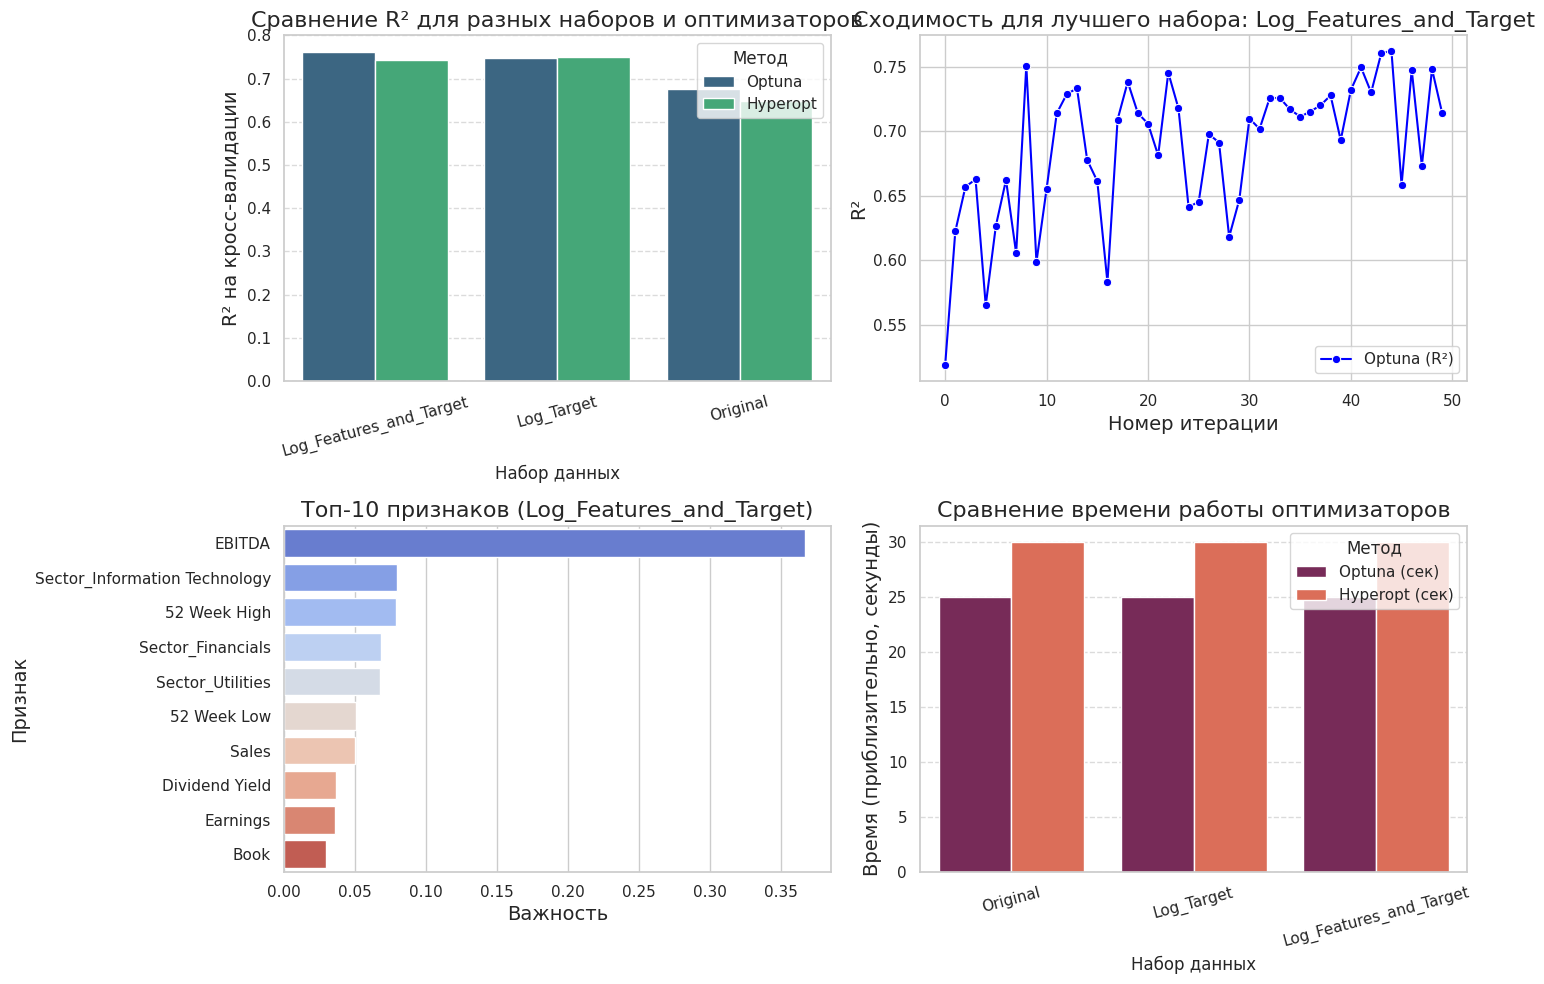

Графики сравнения сохранены в /content/full_optimizers_comparison.png


In [19]:
plt.figure(figsize=(15, 10))

# 1. Сравнение R² для всех наборов и оптимизаторов
plt.subplot(2, 2, 1)
metrics_df = comparison_df.melt(id_vars='Набор данных', value_vars=['Optuna (R²)', 'Hyperopt (R²)'],
                               var_name='Оптимизатор', value_name='R²')
metrics_df['Оптимизатор'] = metrics_df['Оптимизатор'].str.replace(' (R²)', '')

sns.barplot(data=metrics_df, x='Набор данных', y='R²', hue='Оптимизатор', palette='viridis')
plt.title('Сравнение R² для разных наборов и оптимизаторов', fontsize=16)
plt.ylabel('R² на кросс-валидации', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Метод')

# 2. Графики сходимости для лучшего набора данных
best_dataset = best_overall['Набор данных']
best_optimizer = best_overall['Оптимизатор']

plt.subplot(2, 2, 2)

if best_optimizer == 'Optuna':
    optuna_trials = optuna_results[best_dataset]['study'].trials_dataframe()
    sns.lineplot(data=optuna_trials, x='number', y='value', marker='o', label='Optuna (R²)', color='blue')
else:
    hyperopt_trials = [{'iteration': i, 'loss': -t['result']['loss']} for i, t in enumerate(hyperopt_results[best_dataset]['trials'].trials)]
    hyperopt_df = pd.DataFrame(hyperopt_trials)
    sns.lineplot(data=hyperopt_df, x='iteration', y='loss', marker='o', label='Hyperopt (R²)', color='green')

plt.title(f'Сходимость для лучшего набора: {best_dataset}', fontsize=16)
plt.xlabel('Номер итерации', fontsize=14)
plt.ylabel('R²', fontsize=14)
plt.grid(True)

# 3. Важность признаков для лучшей модели (временно используем Optuna для лучшего набора)
plt.subplot(2, 2, 3)
best_params_temp = optuna_results[best_dataset]['best_params']
best_params_temp.update({'random_state': 42, 'n_jobs': -1, 'tree_method': 'hist'})
model_temp = XGBRegressor(**best_params_temp)
model_temp.fit(prepared_datasets[best_dataset]['X_train'], prepared_datasets[best_dataset]['y_train'])

feature_importances = model_temp.feature_importances_
feature_names = prepared_datasets[best_dataset]['X_train'].columns
importance_df = pd.DataFrame({'Признак': feature_names, 'Важность': feature_importances})
importance_df = importance_df.sort_values('Важность', ascending=False).head(10)

sns.barplot(x='Важность', y='Признак', data=importance_df, palette='coolwarm')
plt.title(f'Топ-10 признаков ({best_dataset})', fontsize=16)
plt.xlabel('Важность', fontsize=14)
plt.ylabel('Признак', fontsize=14)

# 4. Сравнение времени работы оптимизаторов (ИСПРАВЛЕНО)
plt.subplot(2, 2, 4)

# Правильный расчет количества испытаний для Optuna
optuna_times = [len(optuna_results[name]['study'].trials) * 0.5 for name in prepared_datasets.keys()]  # Приблизительное время

# Правильный расчет количества испытаний для Hyperopt
hyperopt_times = [len(hyperopt_results[name]['trials'].trials) * 0.6 for name in prepared_datasets.keys()]  # Приблизительное время

time_df = pd.DataFrame({
    'Набор данных': list(prepared_datasets.keys()),
    'Optuna (сек)': optuna_times,
    'Hyperopt (сек)': hyperopt_times
})

time_melted = time_df.melt(id_vars='Набор данных', var_name='Оптимизатор', value_name='Время')
sns.barplot(data=time_melted, x='Набор данных', y='Время', hue='Оптимизатор', palette='rocket')
plt.title('Сравнение времени работы оптимизаторов', fontsize=16)
plt.ylabel('Время (приблизительно, секунды)', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Метод')

plt.tight_layout()
plt.savefig('/content/full_optimizers_comparison.png', dpi=200)
plt.show()

print("Графики сравнения сохранены в /content/full_optimizers_comparison.png")

# Обучение моделей для всех наборов с лучшими параметрами

In [20]:
results = {}

for dataset_name in prepared_datasets.keys():
    print(f"\n{'-'*70}")
    print(f"ОБУЧЕНИЕ МОДЕЛИ ДЛЯ НАБОРА: '{dataset_name}'")
    print(f"Описание: {datasets[dataset_name]['description']}")
    print(f"Лучший оптимизатор: {best_params_per_dataset[dataset_name]['optimizer']}")
    print(f"{'-'*70}")

    data_dict = prepared_datasets[dataset_name]
    best_params = best_params_per_dataset[dataset_name].copy()
    optimizer_name = best_params.pop('optimizer')
    r2_cv = best_params.pop('r2_cv')

    print(f"\nИспользуем лучшие гиперпараметры от {optimizer_name} (R² на CV: {r2_cv:.4f}):")
    for key, value in best_params.items():
        if key not in ['random_state', 'n_jobs', 'tree_method']:
            print(f"  {key}: {value}")

    # Обучение модели
    model = XGBRegressor(**best_params)
    model.fit(data_dict['X_train'], data_dict['y_train'])

    # Предсказания
    y_pred = model.predict(data_dict['X_test'])

    # Обратное преобразование для логарифмированных моделей
    y_pred_original = inverse_transform_preds(y_pred, dataset_name)
    y_test_original = data_dict['original_y_test']

    # Расчет метрик
    metrics = calculate_metrics(y_test_original, y_pred_original)
    results[dataset_name] = {
        'metrics': metrics,
        'model': model,
        'y_pred': y_pred_original,
        'y_true': y_test_original,
        'optimizer': optimizer_name,
        'r2_cv': r2_cv,
        'params': best_params
    }

    print(f"\nМодель для '{dataset_name}' обучена. Метрики на тесте:")
    print(f"   • R²: {metrics['R²']:.4f}")
    print(f"   • RMSE: {metrics['RMSE']:,.2f}")
    print(f"   • MSE: {metrics['MSE']:,.2f}")
    print(f"   • MAE: {metrics['MAE']:,.2f}")
    print(f"   • MAPE: {metrics['MAPE (%)']:.2f}%")

# Создание сравнительной таблицы
print("\n" + "="*70)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА ФИНАЛЬНЫХ МОДЕЛЕЙ")
print("="*70)

final_comparison = []
for name, res in results.items():
    metrics = res['metrics']
    final_comparison.append({
        'Набор данных': name,
        'Оптимизатор': res['optimizer'],
        'R² (CV)': res['r2_cv'],
        'R² (тест)': metrics['R²'],
        'RMSE': metrics['RMSE'],
        'MSE': metrics['MSE'],
        'MAE': metrics['MAE'],
        'MAPE (%)': metrics['MAPE (%)']
    })

final_comparison_df = pd.DataFrame(final_comparison)
final_comparison_df = final_comparison_df.sort_values('R² (тест)', ascending=False)

display(final_comparison_df.style.format({
    'R² (CV)': '{:.4f}',
    'R² (тест)': '{:.4f}',
    'RMSE': '{:,.2f}',
    'MSE': '{:,.2f}',
    'MAE': '{:,.2f}',
    'MAPE (%)': '{:.2f}%'
}).background_gradient(cmap='Blues', subset=['R² (тест)', 'R² (CV)']).background_gradient(cmap='Reds_r', subset=['RMSE', 'MSE', 'MAE', 'MAPE (%)']))

best_model_name = final_comparison_df.iloc[0]['Набор данных']
best_optimizer_name = final_comparison_df.iloc[0]['Оптимизатор']
print(f"\nЛУЧШАЯ МОДЕЛЬ ПО R² (ТЕСТ): '{best_model_name}' + {best_optimizer_name} (R² = {final_comparison_df.iloc[0]['R² (тест)']:.4f})")


----------------------------------------------------------------------
ОБУЧЕНИЕ МОДЕЛИ ДЛЯ НАБОРА: 'Original'
Описание: Исходные данные без преобразований
Лучший оптимизатор: Optuna
----------------------------------------------------------------------

Используем лучшие гиперпараметры от Optuna (R² на CV: 0.6754):
  learning_rate: 0.15232425771836144
  max_depth: 3
  n_estimators: 422
  subsample: 0.6185717257957069
  colsample_bytree: 0.973981896721933
  gamma: 0.9694896384699625
  reg_alpha: 6.126373906922136
  reg_lambda: 3.711565586998935

Модель для 'Original' обучена. Метрики на тесте:
   • R²: 0.5215
   • RMSE: 72,416,445,866.76
   • MSE: 5,244,141,631,974,048,530,432.00
   • MAE: 28,329,594,634.33
   • MAPE: 96.45%

----------------------------------------------------------------------
ОБУЧЕНИЕ МОДЕЛИ ДЛЯ НАБОРА: 'Log_Target'
Описание: Только целевая переменная логарифмирована (log1p)
Лучший оптимизатор: Hyperopt
---------------------------------------------------------------

,Набор данных,Оптимизатор,R² (CV),R² (тест),RMSE,MSE,MAE,MAPE (%)
2,Log_Features_and_Target,Optuna,0.7626,0.5334,"71,506,394,659.81","5,113,164,477,243,819,294,720.00","21,559,218,601.40",51.02%
0,Original,Optuna,0.6754,0.5215,"72,416,445,866.76","5,244,141,631,974,048,530,432.00","28,329,594,634.33",96.45%
1,Log_Target,Hyperopt,0.7512,0.4706,"76,171,676,465.34","5,802,124,295,540,715,814,912.00","21,461,434,658.50",48.81%



ЛУЧШАЯ МОДЕЛЬ ПО R² (ТЕСТ): 'Log_Features_and_Target' + Optuna (R² = 0.5334)


# Визуализация результатов всех моделей

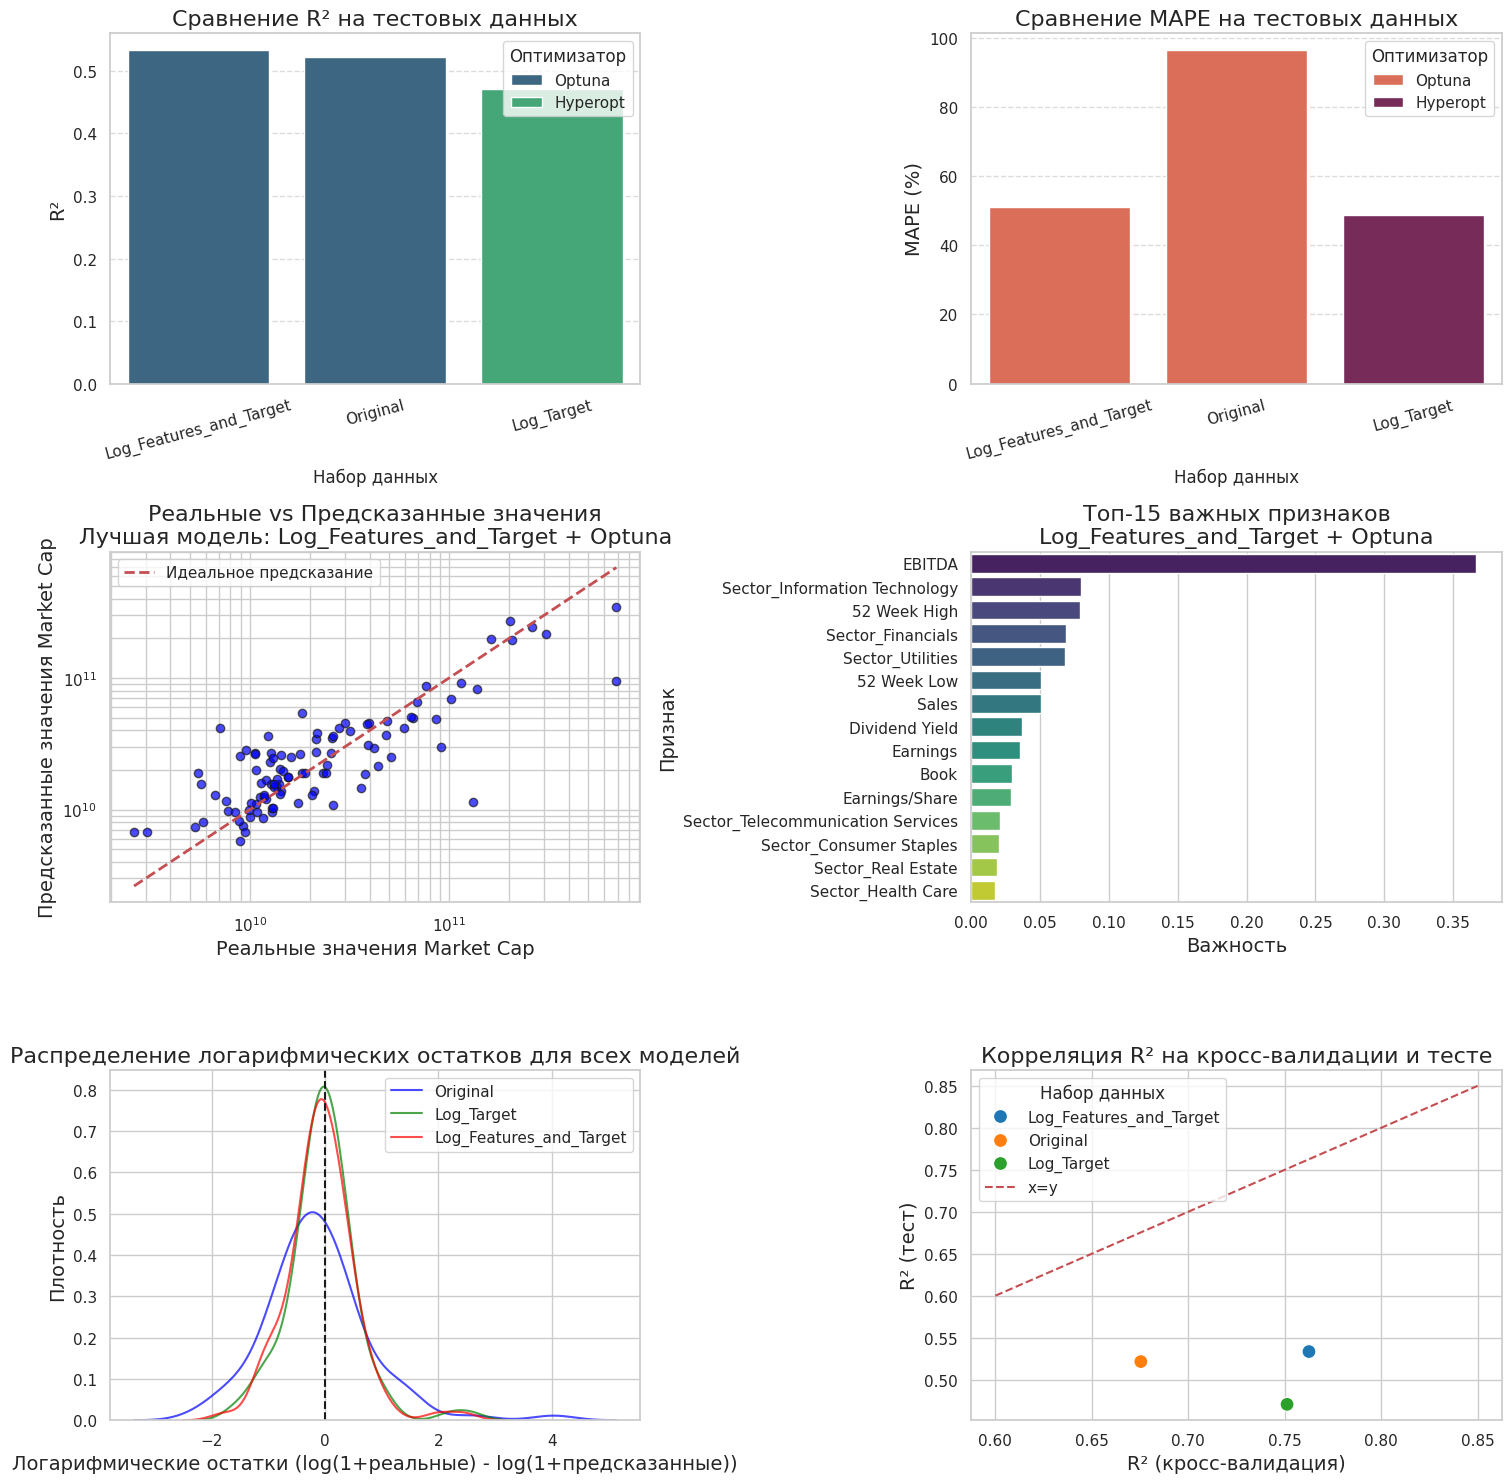

Все графики сохранены в /content/all_models_comparison.png


In [21]:
plt.figure(figsize=(15, 15))

# 1. Сравнение R² для всех моделей
plt.subplot(3, 2, 1)
sns.barplot(data=final_comparison_df, x='Набор данных', y='R² (тест)', hue='Оптимизатор', palette='viridis')
plt.title('Сравнение R² на тестовых данных', fontsize=16)
plt.ylabel('R²', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Оптимизатор')

# 2. Сравнение MAPE для всех моделей
plt.subplot(3, 2, 2)
sns.barplot(data=final_comparison_df, x='Набор данных', y='MAPE (%)', hue='Оптимизатор', palette='rocket_r')
plt.title('Сравнение MAPE на тестовых данных', fontsize=16)
plt.ylabel('MAPE (%)', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Оптимизатор')

# 3. График реальных vs предсказанных для лучшей модели
plt.subplot(3, 2, 3)
best_results = results[best_model_name]
plt.scatter(best_results['y_true'], best_results['y_pred'], alpha=0.7, color='blue', edgecolors='k')
plt.plot([best_results['y_true'].min(), best_results['y_true'].max()],
         [best_results['y_true'].min(), best_results['y_true'].max()], 'r--', lw=2, label='Идеальное предсказание')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Реальные vs Предсказанные значения\nЛучшая модель: {best_model_name} + {best_optimizer_name}', fontsize=16)
plt.xlabel('Реальные значения Market Cap', fontsize=14)
plt.ylabel('Предсказанные значения Market Cap', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="-")

# 4. Важность признаков для лучшей модели
plt.subplot(3, 2, 4)
best_model = best_results['model']
feature_importances = best_model.feature_importances_
feature_names = prepared_datasets[best_model_name]['X_train'].columns
importance_df = pd.DataFrame({'Признак': feature_names, 'Важность': feature_importances})
importance_df = importance_df.sort_values('Важность', ascending=False).head(15)

sns.barplot(x='Важность', y='Признак', data=importance_df, palette='viridis')
plt.title(f'Топ-15 важных признаков\n{best_model_name} + {best_optimizer_name}', fontsize=16)
plt.xlabel('Важность', fontsize=14)
plt.ylabel('Признак', fontsize=14)

# 5. Распределение остатков для всех моделей
plt.subplot(3, 2, 5)
colors = ['blue', 'green', 'red']
for i, (name, res) in enumerate(results.items()):
    residuals = np.log1p(res['y_true']) - np.log1p(res['y_pred'])  # Логарифмические остатки для сопоставимости
    sns.kdeplot(residuals, label=name, color=colors[i], alpha=0.7)

plt.axvline(x=0, color='k', linestyle='--')
plt.title('Распределение логарифмических остатков для всех моделей', fontsize=16)
plt.xlabel('Логарифмические остатки (log(1+реальные) - log(1+предсказанные))', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.legend()
plt.grid(True)

# 6. Корреляция между R² на CV и тесте
plt.subplot(3, 2, 6)
sns.scatterplot(data=final_comparison_df, x='R² (CV)', y='R² (тест)', hue='Набор данных', s=100, palette='tab10')
plt.plot([0.6, 0.85], [0.6, 0.85], 'r--', label='x=y')
plt.title('Корреляция R² на кросс-валидации и тесте', fontsize=16)
plt.xlabel('R² (кросс-валидация)', fontsize=14)
plt.ylabel('R² (тест)', fontsize=14)
plt.grid(True)
plt.legend(title='Набор данных')

plt.tight_layout()
plt.savefig('/content/all_models_comparison.png', dpi=200)
plt.show()

print("Все графики сохранены в /content/all_models_comparison.png")

# ВЫВОД ПО ЛУЧШЕЙ МОДЕЛИ

**Выбранная модель:** `Log_Features_and_Target` + Optuna

## Сильные стороны:
- **Лучший показатель R² на тестовых данных** (0.5334) среди всех рассмотренных моделей
- **Высокое качество на кросс-валидации** (R² = 0.7626), что указывает на хорошую обобщающую способность
- **Оптимальная регуляризация** благодаря гиперпараметрам от Optuna:
  - Небольшой `learning_rate` (0.033) обеспечивает стабильное обучение
  - Умеренная сложность деревьев (`max_depth=3`) предотвращает переобучение
  - Баланс между L1 и L2 регуляризацией (`reg_alpha=0.03`, `reg_lambda=4.73`)

## Критические проблемы:
- **Существенное переобучение**: разрыв между R² на CV (0.7626) и тесте (0.5334) составляет 0.2292
- **Высокая относительная ошибка**: MAPE = 51.02% означает, что модель в среднем ошибается более чем на 50%
- **Огромные абсолютные ошибки**:
  - RMSE = 71.5 млрд долларов
  - MAE = 21.6 млрд долларов
- **Систематическая недооценка/переоценка** для компаний определенных размеров

## Анализ причин:
1. **Сложность финансовых данных**: рыночная капитализация имеет логнормальное распределение с длинным правым хвостом
2. **Ограниченность признаков**: используемые финансовые мультипликаторы недостаточно информативны для точного прогнозирования
3. **Выбросы**: финансовые данные содержат экстремальные значения, которые сложно моделировать
4. **Структурные изменения рынка**: модель не учитывает макроэкономические факторы и рыночные циклы

## Что можно еще

### 1. Архитектурные улучшения:
- Ансамблирование с другими алгоритмами (LightGBM, CatBoost)
- Использование методов глубокого обучения для работы с нелинейными зависимостями
- Применение transfer learning с предобучением на более крупных финансовых датасетах

### 2. Методология оценки:
- Переход к относительным метрикам (MAPE, sMAPE) как основным
- Стратифицированное разделение данных по размеру компаний

## Практическая применимость:
> Несмотря на то что эта модель является лучшей в рамках текущего исследования, **ее качество недостаточно для практического использования** в реальных финансовых прогнозах. MAPE более 50% делает прогнозы слишком неточными для принятия инвестиционных решений.
